In [1]:
from lavis.datasets.builders import load_dataset
from lavis.models import load_model_and_preprocess
from dotenv import load_dotenv
from PIL import Image
from scipy.ndimage import binary_erosion
from typing import List, Tuple
from algo import (
    PITOME,
    TOME,
    DIFFRATE,
    DCT,
    TOFU,
    LTMP,
    NONE, 
    pitome,
    tome,
    DiffRate,
    tofu,
    # ltmp
)
import numpy as np
import torch
import torch.nn.functional as F


FLICKR_PATH='/media/caduser/MyBook/chau/.cache/flickr30k/images'
COCO_PATH='/media/caduser/MyBook/chau/.cache/coco/images'
dataset = load_dataset("coco_retrieval", vis_path=COCO_PATH, cfg_path=None)


Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_train.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_val.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_test.json


In [2]:

from lavis.processors.base_processor import BaseProcessor
from lavis.processors.randaugment import RandomAugment
from omegaconf import OmegaConf
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from lavis.processors.blip_processors import BlipImageBaseProcessor

from main_vl import (
    PITOME,
    TOME, 
    TOFU, 
    DIFFRATE, 
)


In [3]:
class BlipImageEvalProcessor(BlipImageBaseProcessor):
    def __init__(self, image_size=384, mean=None, std=None):
        super().__init__(mean=mean, std=std)

      
        transform_list = [
            transforms.Resize(
                (image_size, image_size), interpolation=InterpolationMode.BICUBIC
            ),
        ]

        # The visualization and model need different transforms
        self.transform_vis  = transforms.Compose(transform_list)
        self.transform = transforms.Compose(transform_list + [
            transforms.ToTensor(),
            self.normalize,
        ])

    def __call__(self, item):
        return self.transform_vis(item), self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 384)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        return cls(image_size=image_size, mean=mean, std=std)

processor = BlipImageEvalProcessor() 


In [4]:

def get_model(model, algo, ratio):
    if algo == PITOME:
        pitome.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        pitome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOME:
        tome.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        tome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOFU:
        tofu.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        tofu.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == DIFFRATE:
        DiffRate.patch.blip(model.visual_encoder, trace_source=True, output_attn=True)
        DiffRate.patch.blip(model.visual_encoder_m, trace_source=True, output_attn=True)
        model.visual_encoder.init_kept_num_using_ratio(ratio)
        model.visual_encoder_m.init_kept_num_using_ratio(ratio)
        # model.visual_encoder.init_kept_num_using_r(0)
        # model.visual_encoder_m.init_kept_num_using_r(0)
    else:
        tome.patch.blip(model.visual_encoder, use_k=False, trace_source=True, output_attn=True)
        tome.patch.blip(model.visual_encoder_m, use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=1.0
        model.visual_encoder_m.ratio=1.0



In [87]:



def generate_colormap(N: int, attention_score: torch.Tensor, seed: int = 0) -> List[Tuple[float, float, float]]:
  """
  Generates a colormap with N elements, with a bolder blue base and lightness adjusted based on attention scores.

  Args:
      N: Number of colors to generate.
      attention_score: A torch.Tensor representing the attention scores.
          This will be used to modulate the lightness of the blue color.
      seed: An optional integer seed for reproducibility.

  Returns:
      A list of tuples representing RGB color values (0.0 to 1.0).
  """



  def adjust_lightness(attention_value):
    normalized_attention = (attention_value - attention_score.min()) / (attention_score.max() - attention_score.min())
    # lightness_adjustment =  normalized_attention  # Adjust factor for lightness range
    base = (1.0, 1.0, 1.0)
    adjusted_color = [base[0]-100.0*normalized_attention, base[1]-100.0*normalized_attention , base[2]]
    return tuple(max(0.0, min(1.0, val)) for val in adjusted_color)

  colormap = [adjust_lightness(attention_value) for attention_value in attention_score.flatten().tolist()]

  return colormap





def make_visualization(
    img: Image, source: torch.Tensor, attention_score:torch.Tensor, patch_size: int = 16, class_token: bool = True
) -> Image:
    """
    Create a visualization like in the paper.

    Args:
     -

    Returns:
     - A PIL image the same size as the input.
    """

    img = np.array(img.convert("RGB")) / 255.0
    source = source.detach().cpu()

    h, w, _ = img.shape
    ph = h // patch_size
    pw = w // patch_size

    if class_token:
        source = source[:, :, 1:]
    vis = source.argmax(dim=1)
    num_groups = vis.max().item() + 1
    print('num_group',num_groups)

    cmap = generate_colormap(num_groups, attention_score)
    vis_img = 0

    for i in range(num_groups):
        mask = (vis == i).float().view(1, 1, ph, pw)
        mask = F.interpolate(mask, size=(h, w), mode="nearest")
        mask = mask.view(h, w, 1).numpy()

        color = (mask * img).sum(axis=(0, 1)) / mask.sum()
        mask_eroded = binary_erosion(mask[..., 0], iterations=1)[..., None]
        mask_edge = mask - mask_eroded

        if not np.isfinite(color).all():
            color = np.zeros(3)
        

        vis_img = vis_img + mask_eroded * color.reshape(1, 1, 3) 
        vis_img = vis_img + mask_edge * 8*np.array(cmap[i]).reshape(1, 1, 3)

    # Convert back into a PIL image
    vis_img = Image.fromarray(np.uint8(vis_img * 255))

    return vis_img


In [88]:
def visualize(algo, ratio, index=None, path='/home/caduser/HDD/vit_token_compress/PiToMe/examples/images/image.jpg'):
    model, _, _ = load_model_and_preprocess("blip_retrieval", "coco", is_eval=False)
    get_model(model,algo, ratio)
    model.eval()
    with torch.no_grad():
        if index is not None:
            img = dataset['train'][index]['image']
        else:
            img = Image.open(path)

        img_vis, img_input = processor(img)
        model.visual_encoder(img_input[None,...])
        if algo == TOME:
            source = model.visual_encoder._tome_info['source']
        elif algo == PITOME:
            source = model.visual_encoder._pitome_info['source']
        elif algo == TOFU:
            source = model.visual_encoder._tofu_info['source']
        elif algo == DIFFRATE:
            source = model.visual_encoder._diffrate_info['source']
        else: 
            source = model.visual_encoder._tome_info['source']
        attn = model.visual_encoder.blocks[-6].attn.attention_map
        print(attn)

        source = model.visual_encoder._pitome_info['sources'][-5]
        print(source.shape)
        return img_vis, make_visualization(img_vis, source, attn.sum(1)[:, 0, :], patch_size=16, class_token=True)

using pitome
using pitome
tensor([[[[5.6877e-01, 1.3431e-03, 1.0828e-03,  ..., 3.1486e-03,
           4.6215e-03, 1.2947e-03],
          [5.5444e-03, 4.7117e-02, 3.7392e-03,  ..., 1.4218e-02,
           6.7286e-04, 1.4685e-04],
          [3.2688e-02, 2.0269e-02, 3.8594e-02,  ..., 1.9636e-02,
           1.4664e-03, 4.7476e-04],
          ...,
          [7.8230e-03, 1.2082e-02, 1.6344e-02,  ..., 5.1127e-02,
           3.1334e-03, 4.1941e-04],
          [1.3010e-02, 7.8654e-04, 2.8086e-03,  ..., 2.6967e-03,
           5.6746e-02, 1.7050e-03],
          [5.0266e-02, 8.6343e-04, 3.1298e-03,  ..., 2.2302e-03,
           9.9108e-03, 2.6297e-02]],

         [[9.6815e-01, 1.0272e-04, 3.0340e-04,  ..., 3.1222e-04,
           3.9897e-05, 1.3675e-04],
          [3.7831e-03, 4.8682e-01, 2.9626e-03,  ..., 3.8472e-03,
           6.1496e-05, 1.6202e-05],
          [9.4342e-03, 1.5059e-03, 4.1688e-01,  ..., 1.6835e-02,
           5.9501e-05, 7.3792e-05],
          ...,
          [1.6402e-02, 4.1330e-03

/tmp/ipykernel_36307/2864009098.py:66: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


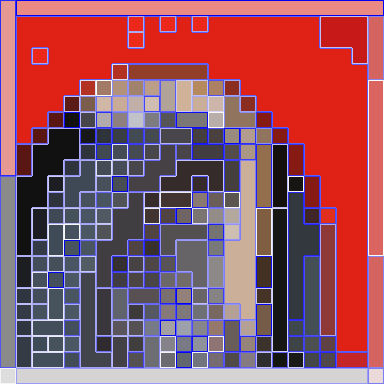

In [89]:
ratio = 0.85
# index = 102 
index = 300 
# index = 6400 
# index = 6665 
# index = 21110 
# index = 15500 
# index = 25000 
# index = 37000 
# index = 47000 
# index = 58000 
# index = 69000 
# index = 69000 
# index = 25000 
img_vis, visualization = visualize(PITOME, ratio, index)
# visualize(PITOME,  ratio)
# img_vis
visualization

In [90]:
visualize(TOME, ratio, index)[1]
# visualize(TOME, ratio)

using tome
using tome
tensor([[[[5.4369e-01, 1.3079e-03, 9.8987e-04,  ..., 3.0253e-03,
           4.2874e-03, 1.7062e-03],
          [5.4824e-03, 4.6894e-02, 2.9395e-03,  ..., 1.3548e-02,
           6.2807e-04, 1.8892e-04],
          [3.9267e-02, 2.0816e-02, 2.9226e-02,  ..., 1.7003e-02,
           1.3108e-03, 5.7047e-04],
          ...,
          [7.8612e-03, 1.1950e-02, 1.2342e-02,  ..., 4.7760e-02,
           2.7904e-03, 5.7522e-04],
          [1.2620e-02, 7.9895e-04, 2.7362e-03,  ..., 2.6784e-03,
           5.5471e-02, 2.7090e-03],
          [6.3722e-02, 7.6631e-04, 2.6114e-03,  ..., 1.5642e-03,
           1.0511e-02, 4.7305e-02]],

         [[9.6693e-01, 1.0042e-04, 2.5790e-04,  ..., 2.9660e-04,
           3.4482e-05, 1.6167e-04],
          [3.6030e-03, 4.7970e-01, 2.3476e-03,  ..., 3.5572e-03,
           6.1561e-05, 1.7073e-05],
          [7.4106e-03, 1.5085e-03, 3.5083e-01,  ..., 1.3314e-02,
           5.8574e-05, 1.3864e-04],
          ...,
          [1.3574e-02, 3.5154e-03, 7.

AttributeError: 'ToMeVisionTransformer' object has no attribute '_pitome_info'

using tofu
using tofu
torch.Size([1, 135, 577])
num_group 135


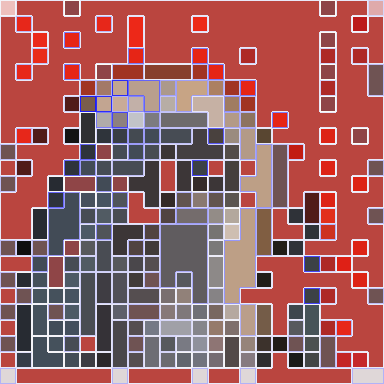

In [ ]:
visualize(TOFU,  ratio, index)[1]

use diffrate
use diffrate
torch.Size([1, 577, 768])
torch.Size([1, 504, 768])
torch.Size([1, 441, 768])
torch.Size([1, 386, 768])
torch.Size([1, 338, 768])
torch.Size([1, 296, 768])
torch.Size([1, 259, 768])
torch.Size([1, 227, 768])
torch.Size([1, 199, 768])
torch.Size([1, 175, 768])
torch.Size([1, 154, 768])
torch.Size([1, 135, 768])
torch.Size([1, 119, 577])
num_group 119


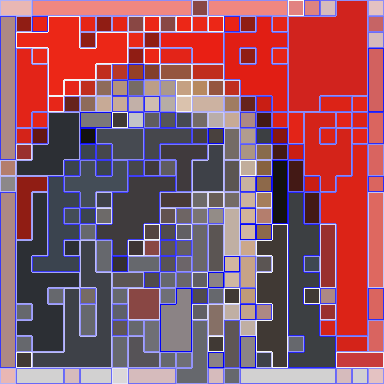

In [10]:
# visualize(DIFFRATE,  ratio)
visualize(DIFFRATE,  ratio, index)[1]

using tome
using tome
torch.Size([1, 577, 577])
num_group 577


/tmp/ipykernel_36307/622879168.py:66: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


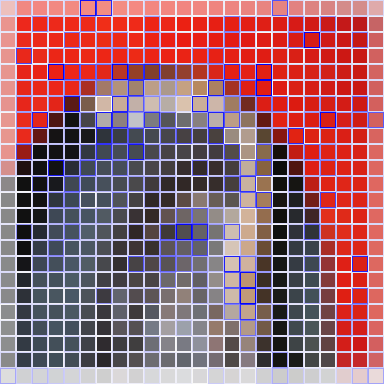

In [11]:
visualize(NONE, ratio=1.0, index=index)[1]
# visualize(NONE, ratio=1.0)